# FFSC Rocket Engine and Regenerative Nozzle Cooling Model

This notebook documents:

1. The **governing equations** for a 1D regenerative nozzle cooling model.
2. A simplified **full-flow staged combustion (FFSC)** cycle model.
3. A Python implementation in the `ffsc_nozzle` package.
4. Example **optimizations and parameter sweeps** using that package.

We assume a methane–oxygen engine (CH₄/LOX), but the structure can be generalized.

## Governing Equations

### Nozzle gas side (1D isentropic + Bartz)

We approximate the core flow as isentropic:

- Area–Mach relation
- Static temperature:
  $$
  T(x) = \frac{T_0}{1 + \frac{\gamma - 1}{2} M(x)^2}
  $$
- Static pressure:
  $$
  p(x) = p_0 \left( \frac{T(x)}{T_0} \right)^{\gamma / (\gamma - 1)}
  $$

We use a Bartz-type correlation for the gas-side convective heat transfer coefficient:
$$
h_g(x) \approx C \,
\frac{\mu_g^{0.2} c_{p,g}^{0.6}}{\mathrm{Pr}_g^{0.6}}\,
p_0^{0.8} r_t^{0.1}\left( \frac{A_t}{A(x)} \right)^{0.9}
\left( \frac{T_0}{T(x)} \right)^{0.55}
$$

### Coolant side (Dittus–Boelter / Gnielinski + Sieder–Tate)

For each axial station, we treat the coolant channel as a turbulent internal flow:

- Hydraulic diameter:
  $$
  D_h = \frac{4 A_c}{P_{\text{wet}}}
  $$
- Reynolds and Prandtl:
  $$
  \mathrm{Re} = \frac{G D_h}{\mu}, \quad \mathrm{Pr} = \frac{c_p \mu}{k}
  $$

We use the Gnielinski correlation:
$$
\mathrm{Nu} =
\frac{(f/8)(\mathrm{Re}-1000)\mathrm{Pr}}{
1 + 12.7 \sqrt{f/8} (\mathrm{Pr}^{2/3} - 1)
}
$$

with a Sieder–Tate viscosity correction:
$$
\mathrm{Nu} \to \mathrm{Nu} \left( \frac{\mu_b}{\mu_w} \right)^{0.14}
$$

Then:
$$
h_c = \frac{\mathrm{Nu}\,k}{D_h}.
$$

### Wall conduction and conjugate heat transfer

We treat the wall as a 1D radial conduction layer:

- Inner gas film, wall, and coolant film form series resistances:
  $$
  R_{\text{tot}} = \frac{1}{h_g} + \frac{t_{\text{wall}}}{k_{\text{wall}}} + \frac{1}{h_c}
  $$
- Heat flux:
  $$
  q''(x) = \frac{T_g(x) - T_{\text{cool}}(x)}{R_{\text{tot}}}
  $$
- Inner wall temperature:
  $$
  T_{\text{wall,in}}(x) = T_g(x) - \frac{q''(x)}{h_g}
  $$

### Coolant energy equation

We integrate the coolant energy along the axial coordinate:

$$
\dot{m}_{\text{cool}} c_{p,c} \frac{d T_{\text{cool}}}{dx}
  = q''(x) P_{\text{inner}}(x)
$$

which we discretize:
$$
T_{\text{cool}, i+1} = T_{\text{cool}, i}
+ \frac{q''_i P_{\text{inner}, i} \Delta x}{\dot{m}_{\text{cool}} c_{p,c,i}}.
$$

### FFSC cycle: Pumps and turbines

- Pump power:
  $$
  P_{\text{pump}} = \frac{\dot{m} \Delta p}{\rho \eta_{\text{pump}}}
  $$
- Turbine power:
  $$
  P_{\text{turb}} = \dot{m} c_p (T_{\text{in}} - T_{\text{out}})\eta_{\text{turb}}
  $$

We require:
$$
P_{\text{turb, fuel}} \gtrsim \frac{P_{\text{pump, fuel}}}{\eta_{\text{mech}}},\quad
P_{\text{turb, ox}}   \gtrsim \frac{P_{\text{pump, ox}}}{\eta_{\text{mech}}}.
$$

### Main chamber thermodynamics

If Cantera is available, we compute an equilibrium CH₄/O₂ state at $p_0$ and O/F:

- $T_0$, $\gamma$, $R_g$ from equilibrium composition.
- This feeds both the nozzle model (for $h_g$) and the performance estimate.

Otherwise, we fall back to a parameterized ideal-gas guess.

## Python Module Configuration/Package Import

In [14]:
# Import the required python packages
import numpy as np
import matplotlib.pyplot as plt

from mermaid import Mermaid
import os, subprocess, shutil
from IPython.display import Image, SVG, display

from modern_aerospace_propulsion.ffsc_nozzle import thermo, regen, cycle, sweep

# Check optional tools
print("Cantera available:", thermo.HAVE_CANTERA)
try:
    from CoolProp.CoolProp import PropsSI
    print("CoolProp available: True")
    HAVE_COOLPROP = True
except ImportError:
    print("CoolProp available: False")
    HAVE_COOLPROP = False

Cantera available: True
CoolProp available: True


## Cantera Combustor Test

In [2]:
# Cantera chamber state test
p0 = 20e6    # Pa
OF = 3.2

if thermo.HAVE_CANTERA:
    T0, gamma, R_g, gas_ch = thermo.cantera_chamber_state(
        OF=OF,
        p0=p0,
        T_fuel=110.0,
        T_ox=90.0,
        fuel_species="CH4",
        ox_species="O2",
        mech="gri30.yaml",
    )
    print(f"Chamber from Cantera: T0={T0:.1f} K, gamma={gamma:.3f}, R_g={R_g:.1f} J/kg/K")
else:
    T0, gamma, R_g = thermo.ideal_gas_chamber_state(OF=OF, p0=p0)
    print(f"Chamber (fallback): T0={T0:.1f} K, gamma={gamma:.3f}, R_g={R_g:.1f} J/kg/K")

Chamber from Cantera: T0=3703.0 K, gamma=1.196, R_g=391.7 J/kg/K


## Nozzle Cooling Test

Total mass flow: 168.37 kg/s
Coolant mass flow: 20.04 kg/s

Max wall temperature: 2950.3 K
Min coolant pressure: 28.70 MPa
Max coolant temperature: 931.0 K


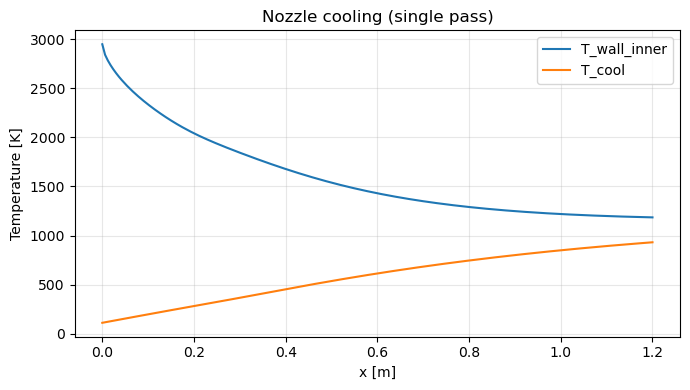

In [4]:
# Run a nozzle cooling test case with more realistic parameters
r_t = 0.10                    # Smaller throat radius
eps = 15.0
L_noz = 1.2                   # Shorter nozzle

x, r, A, At = regen.simple_conical_nozzle(r_t, eps, L_noz, N=200)

# Use Cantera chamber if available
if thermo.HAVE_CANTERA:
    T0, gamma, R_g, _ = thermo.cantera_chamber_state(OF=OF, p0=p0)
else:
    T0, gamma, R_g = thermo.ideal_gas_chamber_state(OF=OF, p0=p0)

# Mass flows for demonstration
F_vac = 5.0e5                 # Reduced thrust to 500 kN
Isp_vac_ideal, _, T_e, M_e = sweep.ideal_vacuum_isp_from_eps(p0, T0, gamma, R_g, eps)
Isp_eff = 0.95*Isp_vac_ideal
g0 = 9.80665
m_dot_total = F_vac/(Isp_eff*g0)
m_dot_fuel = m_dot_total/(1+OF)
m_dot_cool = 0.5*m_dot_fuel   # Use more coolant (50% of fuel flow)

print(f"Total mass flow: {m_dot_total:.2f} kg/s")
print(f"Coolant mass flow: {m_dot_cool:.2f} kg/s")

res_noz = regen.regen_nozzle_1D(
    x=x, r=r, A=A, At=At,
    p0=p0, T0=T0, gamma=gamma, R_g=R_g,
    coolant="LCH4",
    coolant_props=regen.make_coolprop_liquid("Methane") if HAVE_COOLPROP else None,
    m_dot_cool=m_dot_cool,
    n_channels=300,            # More channels
    w_channel=0.003,           # Wider channels
    h_channel=0.004,           # Taller channels
    wall_thickness=0.0015,     # Thinner wall for better heat transfer
    roughness=5e-6,
    T_cool_in=110.0,
    p_cool_in=30e6,            # Higher inlet pressure (30 MPa)
    L_regen=L_noz,             # Cool entire nozzle
)

print(f"\nMax wall temperature: {res_noz['T_wall_inner'].max():.1f} K")
print(f"Min coolant pressure: {res_noz['p_cool'].min()/1e6:.2f} MPa")
print(f"Max coolant temperature: {res_noz['T_cool'].max():.1f} K")

plt.figure(figsize=(7,4))
plt.plot(res_noz["x"], res_noz["T_wall_inner"], label="T_wall_inner")
plt.plot(res_noz["x"], res_noz["T_cool"], label="T_cool")
plt.xlabel("x [m]")
plt.ylabel("Temperature [K]")
plt.legend()
plt.title("Nozzle cooling (single pass)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
# Run full FFSC cycle analysis with adjusted parameters for feasibility
summary = cycle.ffsc_full_flow_cycle(
    F_vac=F_vac,
    p0=p0,
    OF=OF,
    r_t=r_t,
    eps=eps,
    L_noz=L_noz,
    coolant="LCH4",
    use_coolprop=True,
    use_cantera_chamber=True,
    # Cooling parameters from our nozzle test
    n_channels=300,
    w_channel=0.003,
    wall_thickness=0.0015,
    p_cool_in=30e6,
    T_cool_in=110.0,
    # Cycle parameters adjusted for feasibility
    T_pb_min=1200.0,           # Increased from 900K - higher preburner temp
    T_pb_max=4000.0,           # Increased from 3500K - allow hotter preburners
    T_turb_out=1000.0,         # KEY FIX: Turbine exit temp much lower than preburner temp
    eta_pump_fuel=0.75,        # Slightly higher pump efficiency
    eta_pump_ox=0.75,
    eta_turb_fuel=0.92,        # Slightly higher turbine efficiency  
    eta_turb_ox=0.92,
    injector_dp_frac=0.15,     # Reduced from 0.2 - lower injector pressure drop
    feed_line_dp=0.5e6,        # Reduced from 1.0 MPa - lower feed line losses
)

print("\n=== FFSC Cycle Summary ===\n")

# Organize output by category
print("Performance:")
print(f"  F_vac                : {summary['F_vac']/1e3:.1f} kN")
print(f"  Isp_vac_eff          : {summary['Isp_vac_eff']:.1f} s")
print(f"  Isp_vac_ideal        : {summary['Isp_vac_ideal']:.1f} s")
print(f"  Efficiency           : {summary['Isp_vac_eff']/summary['Isp_vac_ideal']*100:.1f}%")

print("\nMass Flows:")
print(f"  m_dot_total          : {summary['m_dot_total']:.2f} kg/s")
print(f"  m_dot_fuel           : {summary['m_dot_fuel']:.2f} kg/s")
print(f"  m_dot_ox             : {summary['m_dot_ox']:.2f} kg/s")
print(f"  m_dot_cool           : {summary['m_dot_cool']:.2f} kg/s")
print(f"  Coolant fraction     : {summary['coolant_fraction']:.1%}")

print("\nChamber State:")
print(f"  T0                   : {summary['T0']:.0f} K")
print(f"  p0                   : {summary.get('p0', p0)/1e6:.1f} MPa")
print(f"  gamma                : {summary['gamma']:.3f}")
print(f"  O/F ratio            : {summary.get('OF', OF):.2f}")

print("\nCooling:")
print(f"  T_wall_max           : {summary['T_wall_max']:.0f} K")
print(f"  dp_cool              : {summary['dp_cool']/1e6:.2f} MPa")

print("\nPressure Rises:")
print(f"  dp_fuel              : {summary['dp_fuel']/1e6:.2f} MPa")
print(f"  dp_ox                : {summary['dp_ox']/1e6:.2f} MPa")

print("\nPump Power Required:")
print(f"  P_pump_fuel          : {summary['P_pump_fuel']/1e6:.3f} MW")
print(f"  P_pump_ox            : {summary['P_pump_ox']/1e6:.3f} MW")
print(f"  P_turb_req_fuel      : {summary['P_turb_req_fuel']/1e6:.3f} MW")
print(f"  P_turb_req_ox        : {summary['P_turb_req_ox']/1e6:.3f} MW")

print("\nPreburner Temperatures:")
print(f"  T_pb_fuel            : {summary['T_pb_fuel']:.0f} K")
print(f"  T_pb_ox              : {summary['T_pb_ox']:.0f} K")

print("\nTurbine Power Available:")
print(f"  P_turb_avail_fuel    : {summary['P_turb_avail_fuel']/1e6:.3f} MW")
print(f"  P_turb_avail_ox      : {summary['P_turb_avail_ox']/1e6:.3f} MW")

print("\nFeasibility:")
fuel_margin = (summary['P_turb_avail_fuel'] - summary['P_turb_req_fuel'])/summary['P_turb_req_fuel']*100
ox_margin = (summary['P_turb_avail_ox'] - summary['P_turb_req_ox'])/summary['P_turb_req_ox']*100
print(f"  Fuel side margin     : {fuel_margin:+.1f}%")
print(f"  Ox side margin       : {ox_margin:+.1f}%")
print(f"  ox_side_ok           : {bool(summary['ox_side_ok'])}")

if summary['ox_side_ok']:
    print("\n✓ FFSC cycle is FEASIBLE - both turbopump sides can be balanced!")
else:
    print("\n✗ FFSC cycle is NOT feasible - turbines cannot provide sufficient power")



=== FFSC Cycle Summary ===

Performance:
  F_vac                : 500.0 kN
  Isp_vac_eff          : 302.8 s
  Isp_vac_ideal        : 318.8 s
  Efficiency           : 95.0%

Mass Flows:
  m_dot_total          : 168.37 kg/s
  m_dot_fuel           : 40.09 kg/s
  m_dot_ox             : 128.28 kg/s
  m_dot_cool           : 8.02 kg/s
  Coolant fraction     : 20.0%

Chamber State:
  T0                   : 3703 K
  p0                   : 20.0 MPa
  gamma                : 1.196
  O/F ratio            : 3.20

Cooling:
  T_wall_max           : 2991 K
  dp_cool              : 2.25 MPa

Pressure Rises:
  dp_fuel              : 25.65 MPa
  dp_ox                : 23.40 MPa

Pump Power Required:
  P_pump_fuel          : 3.264 MW
  P_pump_ox            : 3.511 MW
  P_turb_req_fuel      : 3.330 MW
  P_turb_req_ox        : 3.582 MW

Preburner Temperatures:
  T_pb_fuel            : 3669 K
  T_pb_ox              : 3578 K

Turbine Power Available:
  P_turb_avail_fuel    : 214.033 MW
  P_turb_avail_ox      

Generating single mermaid chart


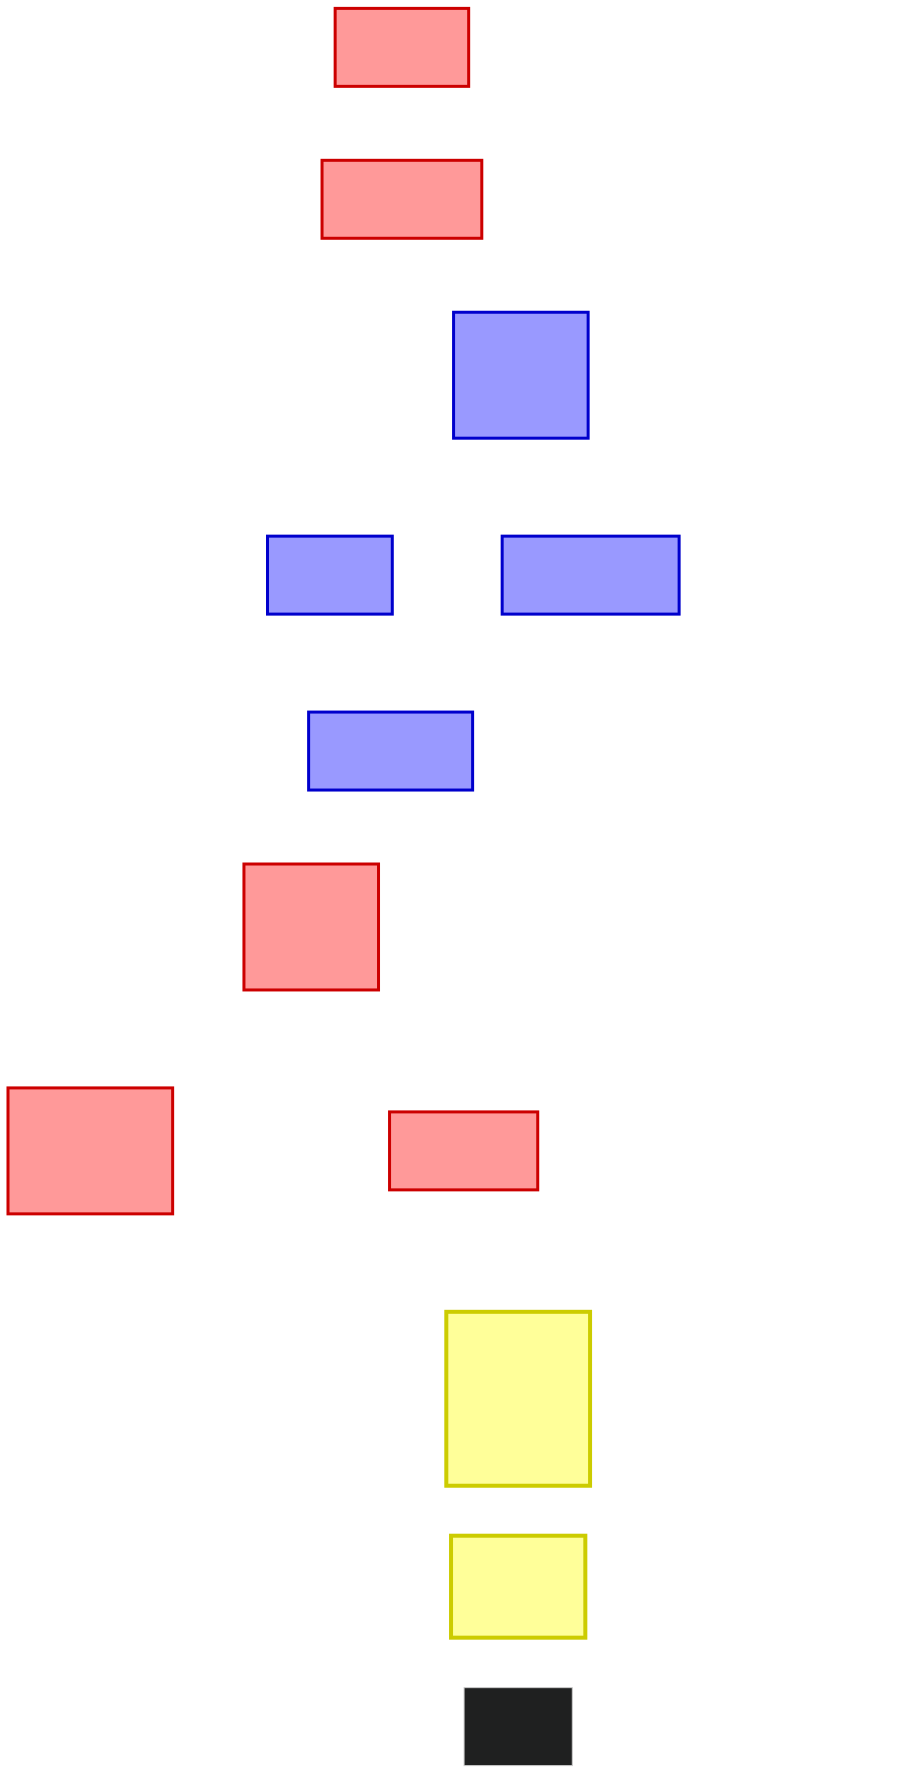

In [17]:
# Dynamically generate Mermaid diagram from FFSC cycle results
use_svg = True
mmd_path = "ffsc_schematic.mmd"
out_svg = "ffsc_schematic.svg"
out_png = "ffsc_schematic.png"

# Extract key values from summary
m_dot_fuel_val = summary['m_dot_fuel']
m_dot_ox_val = summary['m_dot_ox']
m_dot_cool_val = summary['m_dot_cool']
dp_fuel_val = summary['dp_fuel'] / 1e6  # MPa
dp_ox_val = summary['dp_ox'] / 1e6  # MPa
dp_cool_val = summary['dp_cool'] / 1e6  # MPa
T_pb_fuel_val = summary['T_pb_fuel']
T_pb_ox_val = summary['T_pb_ox']
T_wall_max_val = summary['T_wall_max']
T_turb_exit = 1000.0  # From our T_turb_out parameter
dT_fuel_turb = T_pb_fuel_val - T_turb_exit
dT_ox_turb = T_pb_ox_val - T_turb_exit
T_cool_out = summary['T_cool'].max() if 'T_cool' in summary else 930  # From res_noz
dT_cool = T_cool_out - 110.0
T0_val = summary['T0']
p0_val = summary.get('p0', p0) / 1e6  # MPa
eps_val = eps
Isp_val = summary['Isp_vac_eff']
F_vac_val = summary['F_vac'] / 1e3  # kN
OF_val = summary.get('OF', OF)

# Calculate equivalence ratios (phi) for preburners
# Fuel-rich: mostly fuel with small ox amount
phi_fuel_pb = 1.3  # Fuel-rich
# Ox-rich: mostly ox with small fuel amount
phi_ox_pb = 0.7  # Ox-rich (less than stoichiometric)

mermaid_code = f"""%%{{init: {{'theme':'dark','themeVariables': {{'lineColor':'#ffffff','primaryTextColor':'#ffffff'}}}}}}%%
graph TB
    %% Fuel side (left)
    LCH4[LCH4 Tank<br/>~110 K]
    FuelPump[Fuel Pump<br/>ΔP ≈ {dp_fuel_val:.1f} MPa]
    FuelPB[Fuel-Rich<br/>Preburner<br/>φ = {phi_fuel_pb:.1f}<br/>T ≈ {T_pb_fuel_val:.0f} K]
    FuelTurb[Fuel Turbine<br/>ΔT ≈ {dT_fuel_turb:.0f} K]
    %% Oxidizer side (right)
    LOX[LOX Tank<br/>~90 K]
    OxPump[Oxidizer Pump<br/>ΔP ≈ {dp_ox_val:.1f} MPa]
    OxPB[Ox-Rich<br/>Preburner<br/>φ = {phi_ox_pb:.1f}<br/>T ≈ {T_pb_ox_val:.0f} K]
    OxTurb[Oxidizer Turbine<br/>ΔT ≈ {dT_ox_turb:.0f} K]
    %% Cooling system
    Jacket[Regenerative<br/>Cooling Jacket<br/>ΔP ≈ {dp_cool_val:.1f} MPa<br/>ΔT ≈ {dT_cool:.0f} K]
    %% Combustion chamber
    Chamber[Main<br/>Combustion<br/>Chamber<br/>O/F = {OF_val:.1f}<br/>T₀ ≈ {T0_val:.0f} K<br/>p₀ = {p0_val:.0f} MPa]
    Nozzle[Nozzle<br/>ε = {eps_val:.0f}<br/>Isp = {Isp_val:.0f} s]
    Thrust[Thrust<br/>{F_vac_val:.0f} kN]
    %% Fuel flow path
    LCH4 -->|{m_dot_fuel_val:.1f} kg/s| FuelPump
    FuelPump -->|Split| Jacket
    FuelPump -->|To PB| FuelPB
    Jacket -->|Hot CH₄<br/>~{T_cool_out:.0f} K| Chamber
    %% Small amount of LOX to fuel preburner
    OxPump -.->|Small flow| FuelPB
    FuelPB -->|Hot gas<br/>{T_pb_fuel_val:.0f} K| FuelTurb
    FuelTurb -->|~{T_turb_exit:.0f} K| Chamber
    %% Oxidizer flow path  
    LOX -->|{m_dot_ox_val:.1f} kg/s| OxPump
    OxPump -->|Split| OxPB
    OxPump -->|To Chamber| Chamber
    %% Small amount of CH₄ to ox preburner
    FuelPump -.->|Small flow| OxPB
    OxPB -->|Hot gas<br/>{T_pb_ox_val:.0f} K| OxTurb
    OxTurb -->|~{T_turb_exit:.0f} K| Chamber
    %% Power transmission (mechanical coupling)
    FuelTurb -.->|Shaft<br/>Power| FuelPump
    OxTurb -.->|Shaft<br/>Power| OxPump
    %% Exhaust
    Chamber --> Nozzle
    Nozzle --> Thrust
    %% Styling
    classDef fuel fill:#ff9999,stroke:#cc0000,stroke-width:3px,color:#000000
    classDef ox fill:#9999ff,stroke:#0000cc,stroke-width:3px,color:#000000
    classDef hot fill:#ffcc99,stroke:#ff6600,stroke-width:3px,color:#000000
    classDef chamber fill:#ffff99,stroke:#cccc00,stroke-width:4px,color:#000000
    class LCH4,FuelPump,FuelPB,FuelTurb,Jacket fuel
    class LOX,OxPump,OxPB,OxTurb ox
    class Chamber,Nozzle chamber
    
    linkStyle default stroke:#ffffff,stroke-width:3px
"""

# Write the Mermaid source
with open(mmd_path, "w") as f:
    f.write(mermaid_code)

# Ensure mermaid-cli (mmdc) is available
mmdc = shutil.which("mmdc")
if mmdc is None:
    raise RuntimeError("Mermaid CLI 'mmdc' not found. Install with: npm install -g @mermaid-js/mermaid-cli")

# Render via mmdc
if use_svg:
    subprocess.run([mmdc, "-i", mmd_path, "-o", out_svg, "-b", "transparent"], check=True)
    display(SVG(filename=out_svg))
else:
    subprocess.run([mmdc, "-i", mmd_path, "-o", out_png, "-b", "transparent"], check=True)
    display(Image(filename=out_png))

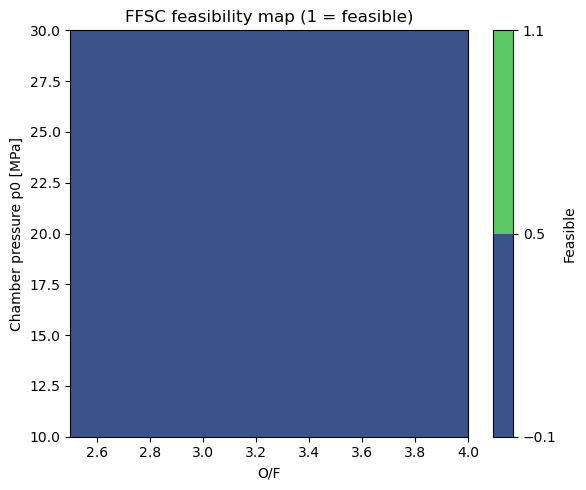

In [16]:
# %% 
p0_array = np.linspace(10e6, 30e6, 5)   # 10–30 MPa
OF_array = np.linspace(2.5, 4.0, 7)     # O/F 2.5–4.0

results = sweep.sweep_ffsc_feasibility(
    F_vac=F_vac,
    r_t=r_t,
    eps=eps,
    L_noz=L_noz,
    p0_array=p0_array,
    OF_array=OF_array,
)

P0 = results["p0_grid"]/1e6   # MPa
OFG = results["OF_grid"]
feas = results["feasible"]

plt.figure(figsize=(6,5))
cs = plt.contourf(
    OFG, P0,
    feas.astype(float),
    levels=[-0.1,0.5,1.1],
)
plt.xlabel("O/F")
plt.ylabel("Chamber pressure p0 [MPa]")
plt.title("FFSC feasibility map (1 = feasible)")
plt.colorbar(label="Feasible")
plt.tight_layout()
plt.show()